In [1]:
# Paste output from benchmark binary. This notebook parses and plots the benchmark results.
benchmark_output = '''
---------------------------------------------------------------------------------------------------------------------------
Benchmark                                                                 Time             CPU   Iterations UserCounters...
---------------------------------------------------------------------------------------------------------------------------
ScanSpeed                                                          16516748 ns     16499575 ns           40 bytes_per_second=2.95936G/s
SplitLines/strchr                                                  45625517 ns     45572000 ns           15 bytes_per_second=1097.17M/s
SplitLines/find_first_of(char)                                     35418252 ns     35388950 ns           20 bytes_per_second=1.37976G/s
SplitLines/find_first_of(str)                                      39082028 ns     39047222 ns           18 bytes_per_second=1.25049G/s
SplitLines/getline                                                218445070 ns    218265667 ns            3 bytes_per_second=229.079M/s
LineTokenize/strpbrk/space_only                                        51.9 ns         51.9 ns     13502045 bytes_per_second=772.381M/s lines_tokenized_per_second=57.85M/s
LineTokenize/strpbrk/space_tab                                         87.9 ns         87.8 ns      7968581 bytes_per_second=456.358M/s lines_tokenized_per_second=34.1804M/s
LineTokenize/strtok/space_only                                         71.0 ns         70.9 ns      9834914 bytes_per_second=565.093M/s lines_tokenized_per_second=42.3245M/s
LineTokenize/strtok/space_tab                                           106 ns          106 ns      6583960 bytes_per_second=377.859M/s lines_tokenized_per_second=28.301M/s
IntFieldParse/from_chars                                               10.4 ns         10.4 ns     67116668 bytes_per_second=641.079M/s fields_converted_per_second=192.063M/s
IntFieldParse/atol                                                     17.5 ns         17.5 ns     39943622 bytes_per_second=381.069M/s fields_converted_per_second=114.166M/s
IntFieldParse/stoll                                                    38.9 ns         38.9 ns     18004162 bytes_per_second=171.709M/s fields_converted_per_second=51.4428M/s
IntFieldParse/strtoll                                                  20.0 ns         19.9 ns     35173405 bytes_per_second=334.664M/s fields_converted_per_second=100.263M/s
IntFieldParse/sscanf                                                   68.9 ns         68.8 ns     10129953 bytes_per_second=97.0492M/s fields_converted_per_second=29.0753M/s
IntFieldParse/istringstream                                             222 ns          222 ns      3149861 bytes_per_second=30.0505M/s fields_converted_per_second=9.00293M/s
DoubleFieldParse/from_chars(fast_float)                                19.5 ns         19.4 ns     35963092 bytes_per_second=687.096M/s fields_converted_per_second=154.387M/s
DoubleFieldParse/strtod                                                49.6 ns         49.5 ns     14123895 bytes_per_second=269.48M/s fields_converted_per_second=60.5507M/s
DoubleFieldParse/sscanf                                                 181 ns          181 ns      3864393 bytes_per_second=73.6455M/s fields_converted_per_second=16.5478M/s
DoubleFieldParse/istringstream                                          389 ns          388 ns      1797947 bytes_per_second=34.3714M/s fields_converted_per_second=7.72307M/s
LineParse/istringstream                                                 959 ns          958 ns       733414 bytes_per_second=41.8218M/s lines_parsed_per_second=3.13238M/s
LineParse/sscanf                                                        350 ns          350 ns      2000171 bytes_per_second=114.462M/s lines_parsed_per_second=8.57298M/s
LineParse/strtoll+strtod                                                109 ns          109 ns      6423433 bytes_per_second=367.714M/s lines_parsed_per_second=27.5412M/s
LineParse/from_chars+strtod/space_only                                 98.0 ns         97.9 ns      7158123 bytes_per_second=409.244M/s lines_parsed_per_second=30.6517M/s
LineParse/from_chars+strtod/space_tab                                  98.7 ns         98.6 ns      7100616 bytes_per_second=406.332M/s lines_parsed_per_second=30.4336M/s
BlockParse/istringstream                                         1103122250 ns   1101762000 ns            1 bytes_per_second=45.3819M/s
BlockParse/from_chars+strtod                                      170702709 ns    170561000 ns            4 bytes_per_second=293.15M/s
BlockParse/from_chars+fast_float                                  130127392 ns    130017800 ns            5 bytes_per_second=384.563M/s
BlockParseParallel/from_chars(fast_float)/0/1/1024/real_time      544925000 ns    544270000 ns            1 bytes_per_second=367.023M/s chunk_size=1024 p=1
BlockParseParallel/from_chars(fast_float)/0/2/1024/real_time      279873896 ns    279044000 ns            2 bytes_per_second=714.608M/s chunk_size=1024 p=2
BlockParseParallel/from_chars(fast_float)/0/3/1024/real_time      192452514 ns    191637000 ns            3 bytes_per_second=1039.22M/s chunk_size=1024 p=3
BlockParseParallel/from_chars(fast_float)/0/4/1024/real_time      149332761 ns    147679250 ns            4 bytes_per_second=1.3079G/s chunk_size=1024 p=4
BlockParseParallel/from_chars(fast_float)/0/5/1024/real_time      121740850 ns    121203400 ns            5 bytes_per_second=1.60433G/s chunk_size=1024 p=5
BlockParseParallel/from_chars(fast_float)/0/6/1024/real_time      104165243 ns    103571333 ns            6 bytes_per_second=1.87503G/s chunk_size=1024 p=6
BlockParseParallel/from_chars(fast_float)/0/7/1024/real_time      106724132 ns     96435167 ns            6 bytes_per_second=1.83007G/s chunk_size=1024 p=7
BlockParseParallel/from_chars(fast_float)/0/8/1024/real_time      108673910 ns     97857167 ns            6 bytes_per_second=1.79723G/s chunk_size=1024 p=8
BlockParseParallel/from_chars(fast_float)/0/1/1048576/real_time   530150875 ns    529962000 ns            1 bytes_per_second=377.251M/s chunk_size=1024k p=1
BlockParseParallel/from_chars(fast_float)/0/2/1048576/real_time   267905820 ns    265851000 ns            3 bytes_per_second=746.531M/s chunk_size=1024k p=2
BlockParseParallel/from_chars(fast_float)/0/3/1048576/real_time   181224646 ns    179992000 ns            4 bytes_per_second=1103.6M/s chunk_size=1024k p=3
BlockParseParallel/from_chars(fast_float)/0/4/1048576/real_time   136296967 ns    135505800 ns            5 bytes_per_second=1.43299G/s chunk_size=1024k p=4
BlockParseParallel/from_chars(fast_float)/0/5/1048576/real_time   109928278 ns    108624667 ns            6 bytes_per_second=1.77673G/s chunk_size=1024k p=5
BlockParseParallel/from_chars(fast_float)/0/6/1048576/real_time    93996597 ns     93622833 ns            6 bytes_per_second=2.07787G/s chunk_size=1024k p=6
BlockParseParallel/from_chars(fast_float)/0/7/1048576/real_time    93843057 ns     83476000 ns            8 bytes_per_second=2.08127G/s chunk_size=1024k p=7
BlockParseParallel/from_chars(fast_float)/0/8/1048576/real_time    89414557 ns     77250750 ns            8 bytes_per_second=2.18435G/s chunk_size=1024k p=8
BlockParseParallel/from_chars(fast_float)/0/1/10485760/real_time  532932000 ns    532655000 ns            1 bytes_per_second=375.282M/s chunk_size=10M p=1
BlockParseParallel/from_chars(fast_float)/0/2/10485760/real_time  268208708 ns    265415333 ns            3 bytes_per_second=745.688M/s chunk_size=10M p=2
BlockParseParallel/from_chars(fast_float)/0/3/10485760/real_time  189340198 ns    188892750 ns            4 bytes_per_second=1056.3M/s chunk_size=10M p=3
BlockParseParallel/from_chars(fast_float)/0/4/10485760/real_time  136582742 ns    134759600 ns            5 bytes_per_second=1.42999G/s chunk_size=10M p=4
BlockParseParallel/from_chars(fast_float)/0/5/10485760/real_time  109977667 ns    108635167 ns            6 bytes_per_second=1.77593G/s chunk_size=10M p=5
BlockParseParallel/from_chars(fast_float)/0/6/10485760/real_time  109392146 ns    109117167 ns            6 bytes_per_second=1.78543G/s chunk_size=10M p=6
BlockParseParallel/from_chars(fast_float)/0/7/10485760/real_time   96510607 ns     85664857 ns            7 bytes_per_second=2.02374G/s chunk_size=10M p=7
BlockParseParallel/from_chars(fast_float)/0/8/10485760/real_time  101659411 ns     87914143 ns            7 bytes_per_second=1.92124G/s chunk_size=10M p=8
BlockParseParallel/from_chars+strtod/1/1/1048576/real_time        697637792 ns    697396000 ns            1 bytes_per_second=286.682M/s chunk_size=1024k p=1
BlockParseParallel/from_chars+strtod/1/2/1048576/real_time        774279250 ns    768209000 ns            1 bytes_per_second=258.305M/s chunk_size=1024k p=2
BlockParseParallel/from_chars+strtod/1/3/1048576/real_time       1002405875 ns    994812000 ns            1 bytes_per_second=199.52M/s chunk_size=1024k p=3
BlockParseParallel/from_chars+strtod/1/4/1048576/real_time       1552496375 ns   1527222000 ns            1 bytes_per_second=128.825M/s chunk_size=1024k p=4
BlockParseParallel/from_chars+strtod/1/5/1048576/real_time       1954871417 ns   1882326000 ns            1 bytes_per_second=102.309M/s chunk_size=1024k p=5
BlockParseParallel/from_chars+strtod/1/6/1048576/real_time       1962116916 ns   1876698000 ns            1 bytes_per_second=101.931M/s chunk_size=1024k p=6
BlockParseParallel/from_chars+strtod/1/7/1048576/real_time       1747413208 ns   1657205000 ns            1 bytes_per_second=114.455M/s chunk_size=1024k p=7
BlockParseParallel/from_chars+strtod/1/8/1048576/real_time       1729102292 ns   1576343000 ns            1 bytes_per_second=115.667M/s chunk_size=1024k p=8
BlockParseParallel/istringstream/2/1/1048576/real_time           4416296083 ns   4413787000 ns            1 bytes_per_second=45.2868M/s chunk_size=1024k p=1
BlockParseParallel/istringstream/2/2/1048576/real_time           5673551333 ns   5662690000 ns            1 bytes_per_second=35.2513M/s chunk_size=1024k p=2
BlockParseParallel/istringstream/2/3/1048576/real_time           7515552417 ns   7504703000 ns            1 bytes_per_second=26.6115M/s chunk_size=1024k p=3
BlockParseParallel/istringstream/2/4/1048576/real_time           1.4236e+10 ns   1.4089e+10 ns            1 bytes_per_second=14.049M/s chunk_size=1024k p=4
BlockParseParallel/istringstream/2/5/1048576/real_time           1.3916e+10 ns   1.3838e+10 ns            1 bytes_per_second=14.3721M/s chunk_size=1024k p=5
BlockParseParallel/istringstream/2/6/1048576/real_time           1.5068e+10 ns   1.5035e+10 ns            1 bytes_per_second=13.2731M/s chunk_size=1024k p=6
BlockParseParallel/istringstream/2/7/1048576/real_time           1.9039e+10 ns   1.8557e+10 ns            1 bytes_per_second=10.5049M/s chunk_size=1024k p=7
BlockParseParallel/istringstream/2/8/1048576/real_time           1.9798e+10 ns   1.8657e+10 ns            1 bytes_per_second=10.1021M/s chunk_size=1024k p=8
'''

save_images_used_in_readme = False
figure_show_mode = 'svg' # 'svg' is inline and visible in GitHub, None is native interactive plotly plots that are not visible in GitHub and several MB in size

In [2]:
def format_bytes(f: int):
    mags = {
        "B": 0,
        "KiB": 2**10,
        "MiB": 2**20,
        "GiB": 2**30,
        "TiB": 2**40,
    }
    best_unit = "B"
    for unit, multiplier in mags.items():
        if mags[best_unit] <= multiplier <= f:
            best_unit = unit

    value = f if mags[best_unit] == 0 else f/mags[best_unit]
    return f"{value:0.2g} {best_unit}"

def parse_float_with_magnitude(f: str):
    mags = {
        "K": 10**3,
        "k": 10**3,
        "M": 10**6,
        "G": 10**9,
        "T": 10**12,
    }
    mag = mags.get(f[-1], 1)
    if mag != 1:
        f = f[:-1]
    return float(f) * mag


def parse_google_benchmark_output(gbm):
    import jc

    # Add an extra space between column headers. If there's only one space then jc will parse it as one column.
    gbm = gbm.replace("Iterations UserCounters", "Iterations  UserCounters")
    res = jc.parse("asciitable", gbm, raw=True)

    for row in res:
        # Break out the benchmark variants
        bench = row["Benchmark"]
        i = bench.find("/")
        if i > 0:
            row["Group"] = bench[0:i]
            row["Variant"] = bench[i+1:]
        else:
            row["Group"] = bench

        # Parse the user counters
        if "UserCounters" in row:
            counters = row["UserCounters"].split(" ")
            for counter in counters:
                k, v = counter.split("=")
                v = v.removesuffix("/s")
                row[k] = parse_float_with_magnitude(v)
    return res


In [3]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame(parse_google_benchmark_output(benchmark_output))
df.sort_values(by='bytes_per_second', ascending=True, inplace=True)

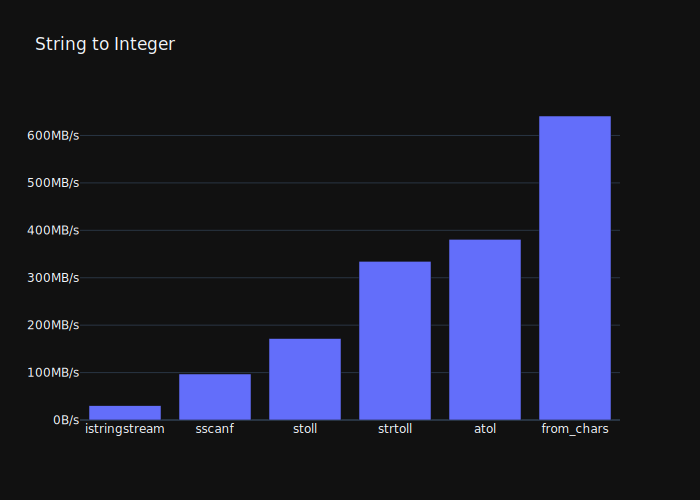

In [4]:
fig = px.bar(df[df.Group=="IntFieldParse"], x='Variant', y='bytes_per_second', title="String to Integer")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
    ),
    xaxis = dict(title=None)
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("string-to-integer.svg")

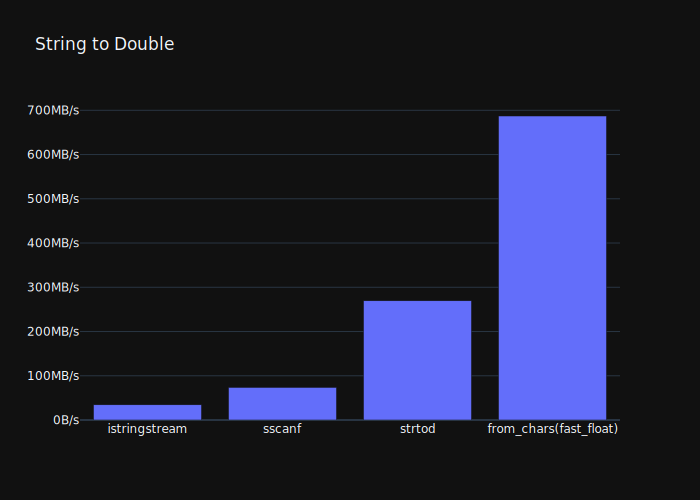

In [5]:
fig = px.bar(df[df.Group=="DoubleFieldParse"], x='Variant', y='bytes_per_second', title="String to Double")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
    ),
    xaxis = dict(title=None)
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("string-to-double.svg")

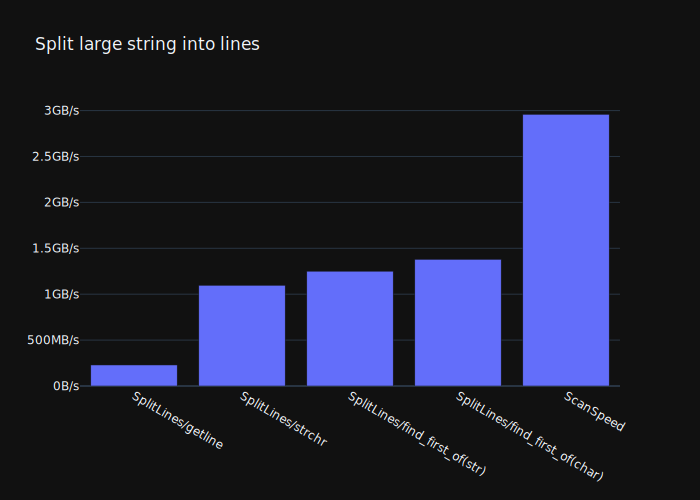

In [6]:
data = df[df["Group"].isin(["ScanSpeed", "SplitLines"])]

fig = px.bar(data, x='Benchmark', y='bytes_per_second', title="Split large string into lines")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        tickformat = '~s'
    ),
    xaxis = dict(title=None)
)
fig.show(figure_show_mode)


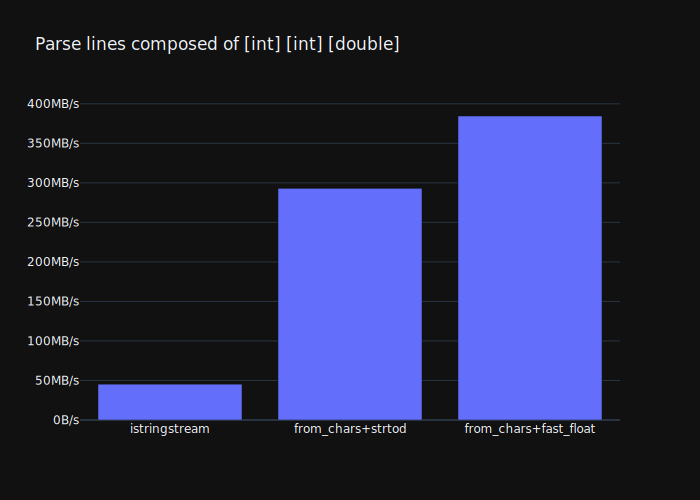

In [7]:
data = df[df["Group"].isin(["BlockParse"])]

fig = px.bar(data, x='Variant', y='bytes_per_second', title="Parse lines composed of [int] [int] [double]")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
    ),
    xaxis = dict(title=None)
)
fig.show(figure_show_mode)

In [8]:
pardata = df[df["Group"].isin(["BlockParseParallel"])].copy()
pardata["ParVariant"] = pardata["Variant"].str.split("/").str[0]
pardata["ChunkSizeInt"] = pardata["Variant"].str.split("/").str[3].astype(int)
pardata["ChunkSize"] = pardata["ChunkSizeInt"].transform(format_bytes)

pardata.sort_values(by=['ParVariant', 'p', 'ChunkSizeInt'], ascending=[True, True, False], inplace=True)

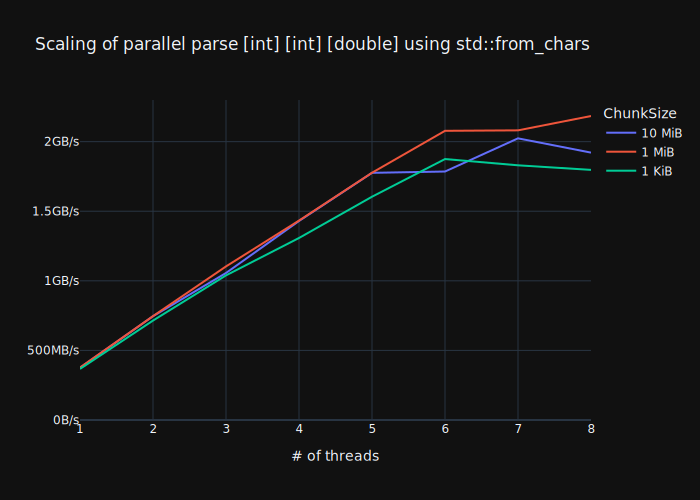

In [9]:
data = pardata[pardata["ParVariant"].isin(["from_chars(fast_float)"])]

fig = px.line(data, x='p', y='bytes_per_second', title="Scaling of parallel parse [int] [int] [double] using std::from_chars", color="ChunkSize")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        rangemode = 'tozero',
        tickformat = '~s'
    ),
    xaxis = dict(title='# of threads')
)
fig.show(figure_show_mode)

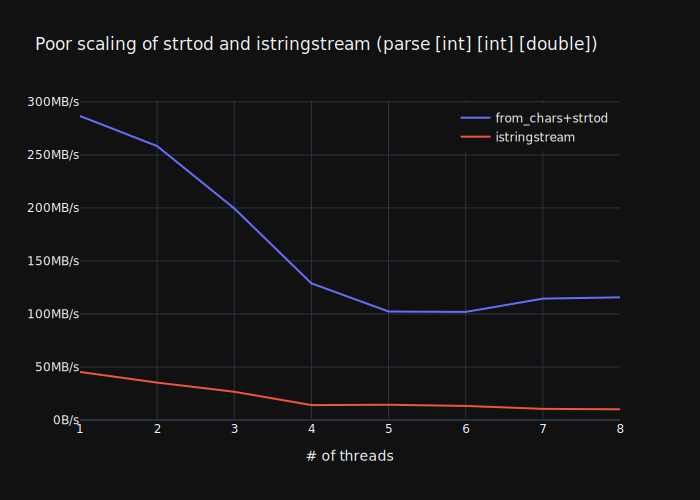

In [10]:
data = pardata[pardata["ParVariant"].isin(["from_chars+strtod", 'istringstream'])]

fig = px.line(data, x='p', y='bytes_per_second', title="Poor scaling of strtod and istringstream (parse [int] [int] [double])", color="ParVariant")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        rangemode = 'tozero',
        tickformat = '~s'
    ),
    xaxis = dict(title='# of threads'),
        legend=dict(
        title=None,
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
)
fig.show(figure_show_mode)

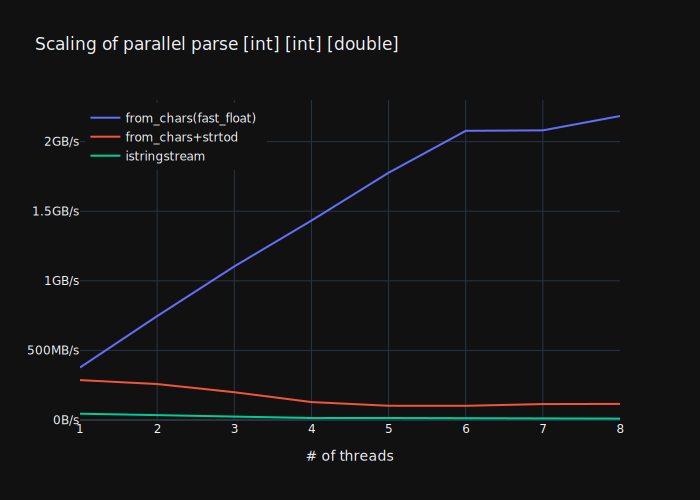

In [11]:
data = pardata[pardata["ParVariant"].isin(["from_chars(fast_float)", "from_chars+strtod", 'istringstream'])]
data = data[data["ChunkSize"].isin(["1 MiB"])]

fig = px.line(data, x='p', y='bytes_per_second', title="Scaling of parallel parse [int] [int] [double]", color="ParVariant")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        rangemode = 'tozero',
        tickformat = '~s'
    ),
    xaxis = dict(title='# of threads'),
    legend=dict(
        title=None,
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("parallel-parse-scaling.svg")